## Deep Q-Learning in CartPole game with Replay Memory

In [1]:
import time
import numpy as np

import gym

import tensorflow as tf
print(f'Tensorflow version: {tf.__version__}')
print(f'GYM version: {gym.__version__}')

import matplotlib.pyplot as plt
%matplotlib inline

Tensorflow version: 2.7.0
GYM version: 0.23.1


## Load GYM environment

In [2]:
env = gym.make('CartPole-v1')

STATE_LIMITS = env.observation_space
NUM_ACTIONS = env.action_space.n

print(f'Actions: {NUM_ACTIONS}')
print('States limits:')
for i in range(STATE_LIMITS.shape[0]):
    print(f'[{STATE_LIMITS.low[i]}, {STATE_LIMITS.high[i]}]')
    """

    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.419 rad (-24°)  | ~ 0.419 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    **Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

    """

Actions: 2
States limits:
[-4.800000190734863, 4.800000190734863]
[-3.4028234663852886e+38, 3.4028234663852886e+38]
[-0.41887903213500977, 0.41887903213500977]
[-3.4028234663852886e+38, 3.4028234663852886e+38]


## DQN Model

In [3]:
import random

from collections import deque
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [4]:
model2 = Sequential([
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(NUM_ACTIONS, activation=None, use_bias=False),
])

In [5]:
model3 = Sequential([
    layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform',),
    layers.Dense(128, activation=tf.nn.relu, kernel_initializer='he_uniform'),
    layers.Dense(64, activation=tf.nn.relu, kernel_initializer='he_uniform'),
    layers.Dense(NUM_ACTIONS, activation='linear', use_bias=False),
])

In [6]:
model=model3
optimizer = RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)
#optimizer = SGD(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

pathLenList, totalRewardList, totalRewardAverageList = [], [], []

## DQN training

In [7]:
def evalQ(s):
    """
    to evaluate Q-function by FCN
    :param s: current state
    :return: numpy array of actions
    """
    return model(s[None, ...].astype(np.float32)).numpy()[0]

In [8]:
def act(epsilon):
    """
    epsilon-greedy implementation: choosing a random action with probability epsilon
    :param epsilon: epsilon
    :return: action
    """
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q_s)
    return action

In [9]:
# query of stack of values of episodes
memory=deque(maxlen=2000)

def remember(state, action, reward, next_state, done):
    """
    function to remember SARS of episodes
    """
    memory.append((state, action, reward, next_state, done))

### Settings

In [10]:
GAMMA = 0.95

NUM_EPISODES = 2000
MAX_STEPS = 100
REWARD_AVERAGE_WINDOW = 20
TRAIN_START = 500
BATCH = 64
STATE_SIZE = STATE_LIMITS.shape[0]

In [11]:
def replay():
    """
    implementation of 'experience replay'  trick to make better inference of FCN
    :return:
    """
    if len(memory) < TRAIN_START:
        return
    # make minibatch with randon episode steps and call variables for SARS
    minibatch = random.sample(memory, BATCH)
    state = np.zeros((BATCH,STATE_SIZE))
    next_state = np.zeros((BATCH,STATE_SIZE))
    action, reward, done = [], [], []

    # fill variables with data from minibatch
    for i in range(BATCH):
        state[i] = minibatch[i][0]
        action.append(minibatch[i][1])
        reward.append(minibatch[i][2])
        next_state[i] = minibatch[i][3]
        done.append(minibatch[i][4])

    # do prediction for state and next state
    target = model.predict(state)
    target_next = model.predict(next_state)

    for i in range(BATCH):
        # correction on the Q value for the action used
        if done[i]:
            target[i][action[i]] = reward[i]
        else:
            # Standard - DQN
            # DQN chooses the max Q value among next actions
            # selection and evaluation of action is on the target Q Network
            target[i][action[i]] = reward[i] + GAMMA * (np.amax(target_next[i]))

    # Train the Fully Connection Neural Network with batches
    model.fit(state, target, batch_size=BATCH, verbose=0)

In [12]:
for i in range(NUM_EPISODES):
    #epsilon decrement
    eps = 1./((i/50) + 10)
    
    s = env.reset()
    
    totalReward, step = 0, 0
    
    while step < MAX_STEPS:
        step += 1

        # calculate variables and Q-values
        Q_s = evalQ(s)
        a = act(eps)
        s1, r, done, _ = env.step(a)
        Q_s1 = evalQ(s1)
        Q_target = Q_s

        # calculate reward
        if done:
            Q_target[a] = r                                 # if last step
        else:
            Q_target[a] = r + GAMMA * np.max(Q_s1)          # if non-last step

        # Train the Fully Connection Neural Network with batches
        model.train_on_batch(s[None, ...].astype(np.float32), Q_target[None, ...])

        totalReward += r
        remember(s,a,r,s1,done)                             # remember results
        s = s1
        
        if done:
            break

        replay()                                            # make 'experience replay'  trick

    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print(f'Episode {i}: average total reward = {totalRewardAverage}')

    # early stop if training reach maximum
    if np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW*2:]) == MAX_STEPS:
        break

Episode 100: average total reward = 9.95
Episode 200: average total reward = 95.0


## Plot trajectory length over time

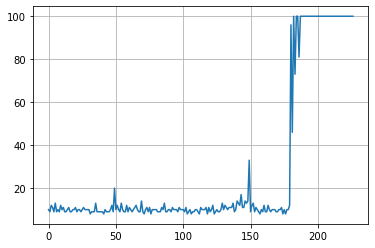

In [13]:
plt.plot(pathLenList)
plt.grid()

## Plot average total reward over time

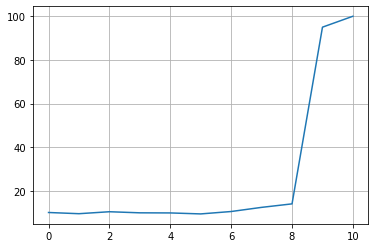

In [14]:
plt.plot(totalRewardAverageList)
plt.grid()

## Run simulation

In [15]:
RECORD_VIDEO = False
USE_Q = True

if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env
    
s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    #env_sim.render()
    if USE_Q:
        a = np.argmax(evalQ(s))
    else:
        a = env_sim.action_space.sample()    
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if done:
        break
       
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print(f'Total reward = {totalReward}')

Total reward = 160.0
